# Data preparation

## Library import

In [165]:
import pandas as pd
import numpy as np

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Flatten
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense, concatenate
from tensorflow.keras.models import Model

from keras_tuner import HyperModel
from keras_tuner import Objective
from keras_tuner.tuners import BayesianOptimization

from keras.regularizers import l1, l2, l1_l2

from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as font_manager

import time

import shutil



from keras_tuner.tuners import BayesianOptimization
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import legacy as legacy_optimizers

## Use Colissimo font for Matplotlib

In [131]:
font_path = '/Users/anthony/spyder-py3/Font/Monserrat/Montserrat-Regular.otf'

font_manager.fontManager.addfont(font_path)

plt.rcParams['font.family'] = 'Montserrat'

## Read dataset

In [132]:
# Read main data
data = pd.read_excel('data/traffic_tg1.xlsx', index_col='date')
data.index = pd.to_datetime(data.index)

# Read holiday day data
holidays_data = pd.read_excel('data/public_holiday.xlsx')
holidays_data['date'] = pd.to_datetime(holidays_data['date'])

# Read school holiday data
school_holidays_data = pd.read_csv('data/school_holiday.csv', sep=",", index_col='date')
school_holidays_data.index = pd.to_datetime(school_holidays_data.index)

# Read Google trends data
Google_trends_data = pd.read_csv('data/google_trends.csv', sep=",", index_col='date')
Google_trends_data.index = pd.to_datetime(Google_trends_data.index)

# Read Google trends data monthly
Google_trends_data_monthly = pd.read_csv('data/google_trends_monthly.csv', sep=",", index_col='date')
Google_trends_data_monthly.index = pd.to_datetime(Google_trends_data_monthly.index)

# Read weather data
weather_data = pd.read_csv('data/weather/weather_data.csv', sep=",", index_col='date')
weather_data.index = pd.to_datetime(weather_data.index)

# Read weather stat data
weather_stats = pd.read_csv('data/weather/weather_stats.csv', sep=",", index_col='date')
weather_stats.index = pd.to_datetime(weather_data.index)





## Create dummies

In [133]:
#Create dummies

# Create a dummy for holiday in France
data['is_holiday'] = data.index.isin(holidays_data['date']).astype(int)

# Create a dummy for Peak period
# Peak period between 11/01 and 12/24
data['Peak_period'] = np.where(
    (data.index.month == 11) | ((data.index.month == 12) & (data.index.day <= 24)), 1, 0
)
# Create a dummy for Covid lockdown in France
# Lockdown date
lockdown_periods = [
    (pd.Timestamp('2020-03-17'), pd.Timestamp('2020-05-11')),
    (pd.Timestamp('2020-10-30'), pd.Timestamp('2020-12-15')),
    (pd.Timestamp('2021-04-03'), pd.Timestamp('2021-05-03'))
]

# Create 0 array with same length as data
lockdown_array = np.zeros(len(data), dtype=int)

# Update array for each lockdown period
for start, end in lockdown_periods:
    lockdown_array = np.where(
        (data.index >= start) & (data.index <= end), 1, lockdown_array
    )

# Add lockdown array to data
data['Confinement'] = lockdown_array


## Concatenate data

In [134]:
# Décaler l'index de google_trends_data et de weather d'un jour
google_trends_data_shifted = Google_trends_data.copy()
google_trends_data_shifted.index = google_trends_data_shifted.index + pd.Timedelta(days=1)

google_trends_data_shifted_monthly = Google_trends_data_monthly.copy()
google_trends_data_shifted_monthly.index = google_trends_data_shifted_monthly.index + pd.Timedelta(days=1)

weather_stats_shifted = weather_stats.copy()
weather_stats_shifted.index = weather_stats_shifted.index + pd.Timedelta(days=1)











In [135]:
#delete first date because I don't have trend for this date
data = data[1:]

In [136]:
#interpolate traffic for holiday
data['tg1_traffic'].replace(0, np.nan, inplace=True)
data['tg1_traffic'] = data['tg1_traffic'].interpolate(method='linear')

<Axes: xlabel='date'>

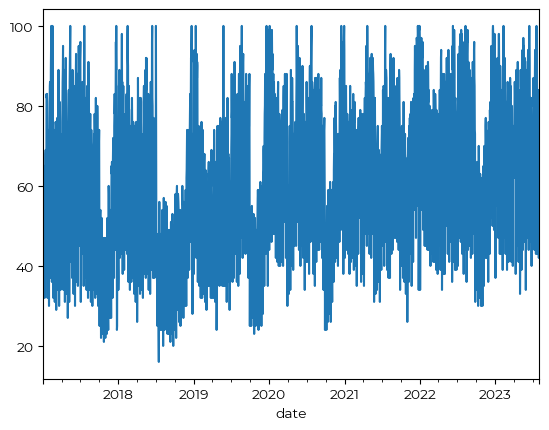

In [120]:
google_trends_data_shifted['colis'].plot()


<Axes: xlabel='date'>

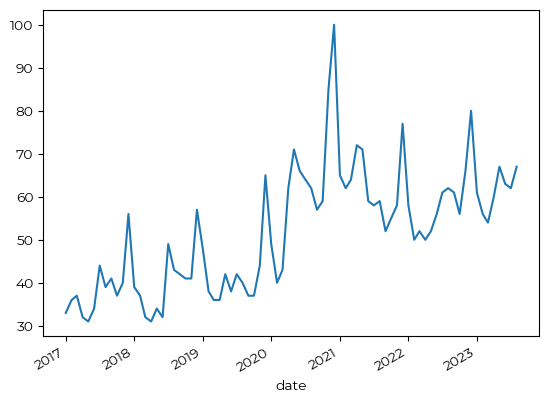

In [121]:
google_trends_data_shifted_monthly['colis'].plot()


In [139]:
google_trends_data_shifted_monthly = google_trends_data_shifted_monthly.reindex(Google_trends_data.index).ffill()




for column in google_trends_data_shifted.columns:
    if column in google_trends_data_shifted_monthly.columns:
        google_trends_data_shifted[column] *= google_trends_data_shifted_monthly[column]/100
        




<Axes: xlabel='date'>

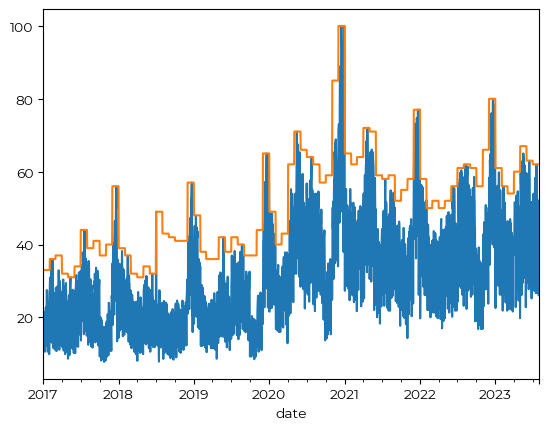

In [140]:
google_trends_data_shifted['colis'].plot()
google_trends_data_shifted_monthly['colis'].plot()



In [141]:
data = data.join([weather_stats_shifted, school_holidays_data, google_trends_data_shifted])

In [142]:
print(data)

            tg1_traffic  is_holiday  Peak_period  Confinement  t_mean_mean  \
date                                                                         
2017-01-02      24323.0         0.0          0.0          0.0     1.904762   
2017-01-03      21964.0         0.0          0.0          0.0     2.921429   
2017-01-04      20347.0         0.0          0.0          0.0     1.821429   
2017-01-05      20753.0         0.0          0.0          0.0     2.271429   
2017-01-06      20430.0         0.0          0.0          0.0     2.950000   
...                 ...         ...          ...          ...          ...   
2023-07-24      33712.0         0.0          0.0          0.0    21.590244   
2023-07-25      26491.0         0.0          0.0          0.0    19.092683   
2023-07-26      27964.0         0.0          0.0          0.0    19.441463   
2023-07-27      23391.0         0.0          0.0          0.0    18.836585   
2023-07-28      23015.0         0.0          0.0          0.0   

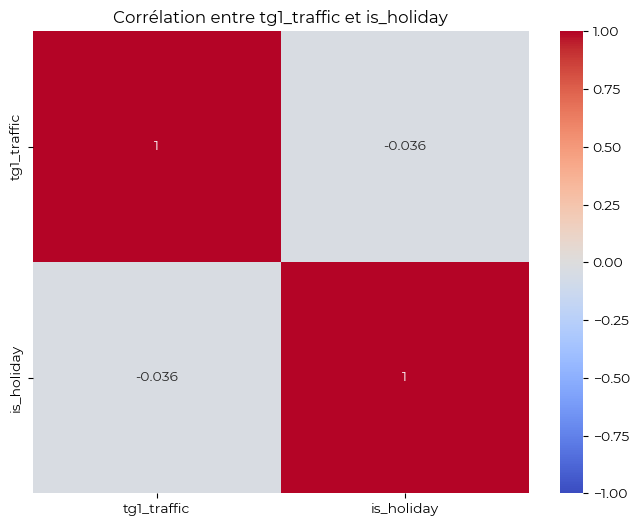

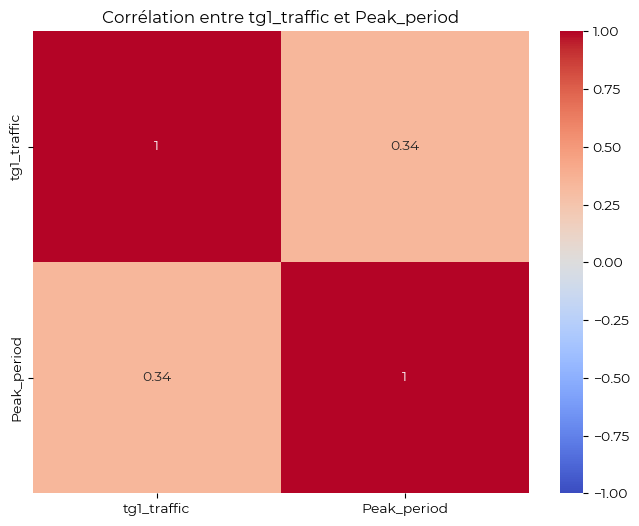

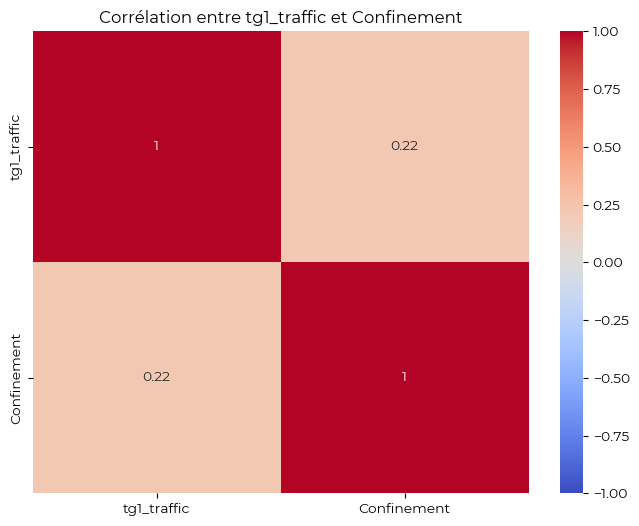

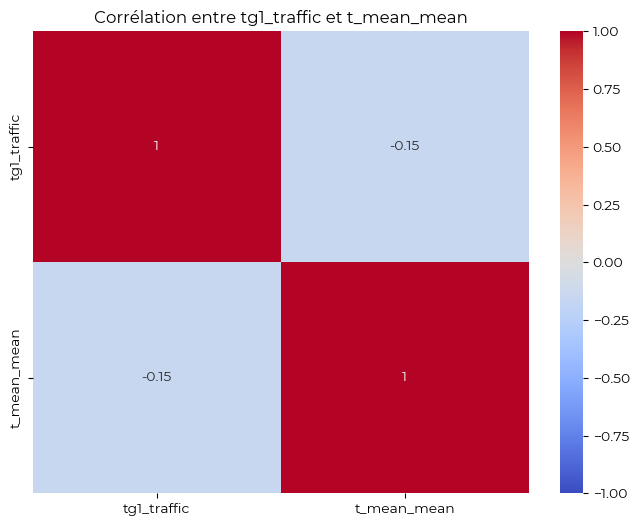

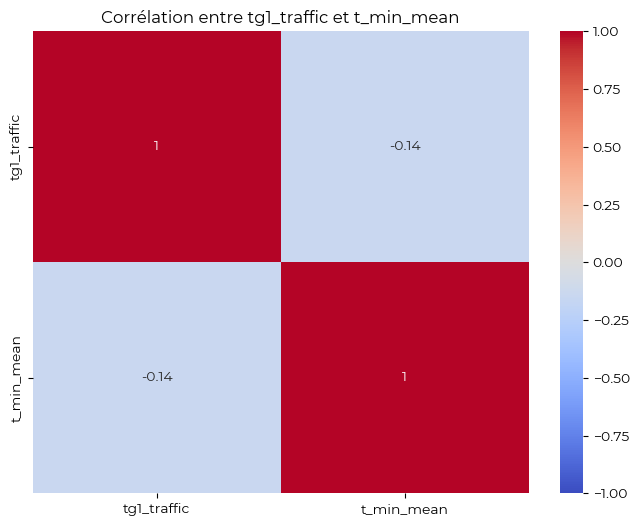

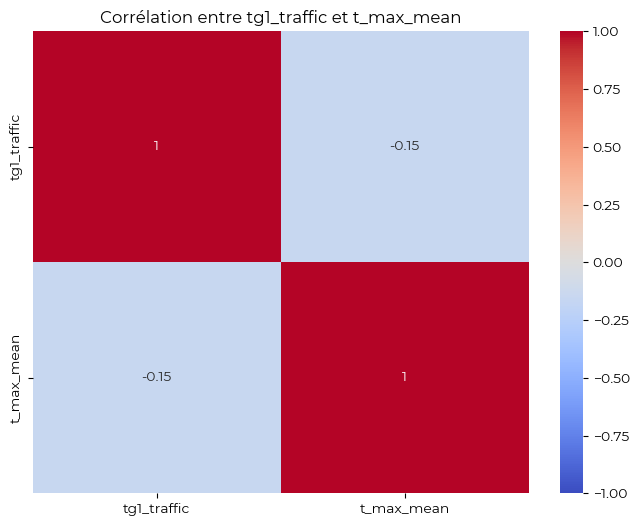

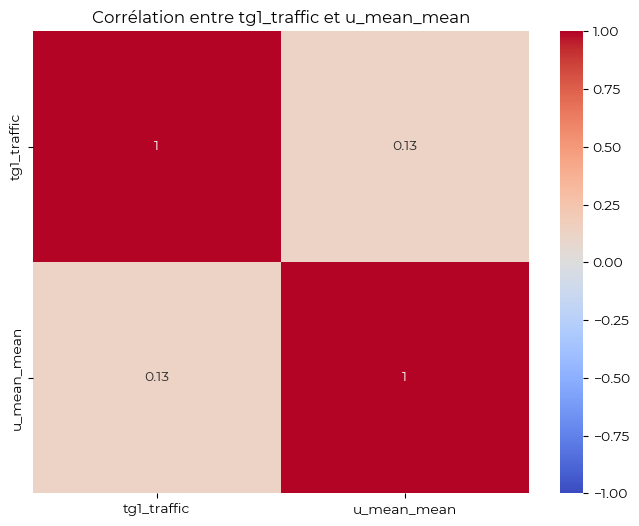

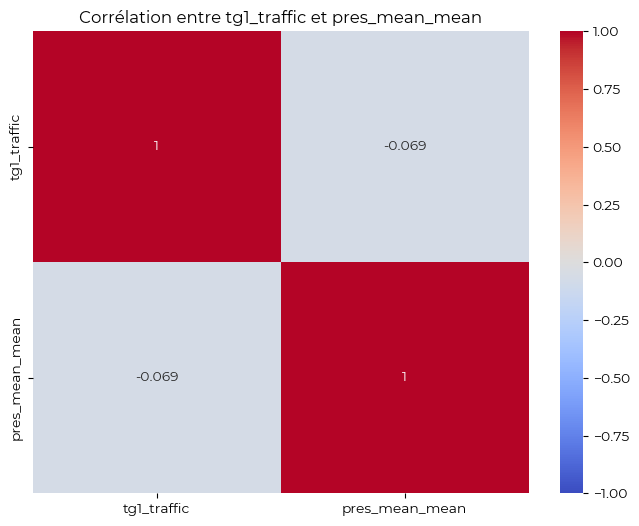

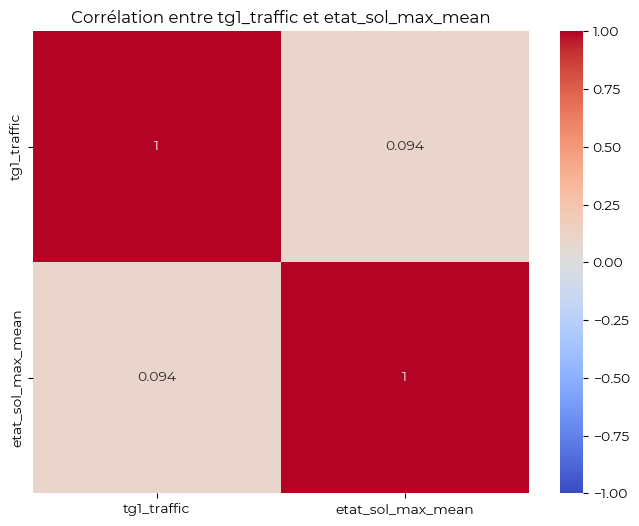

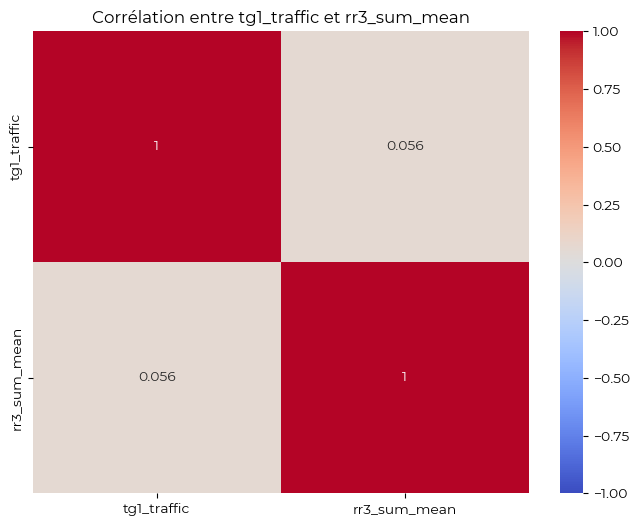

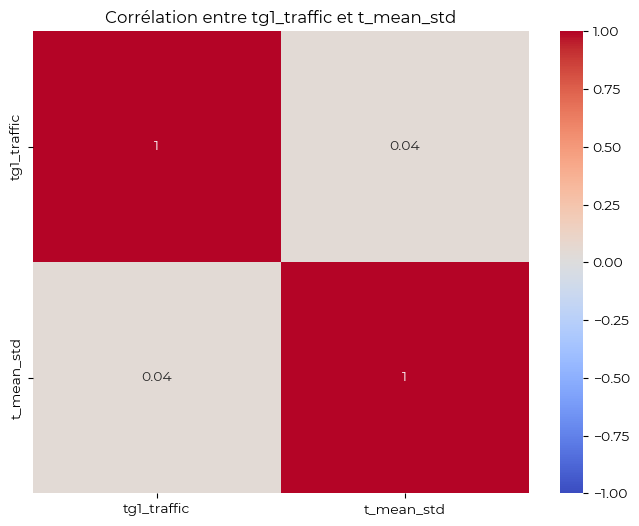

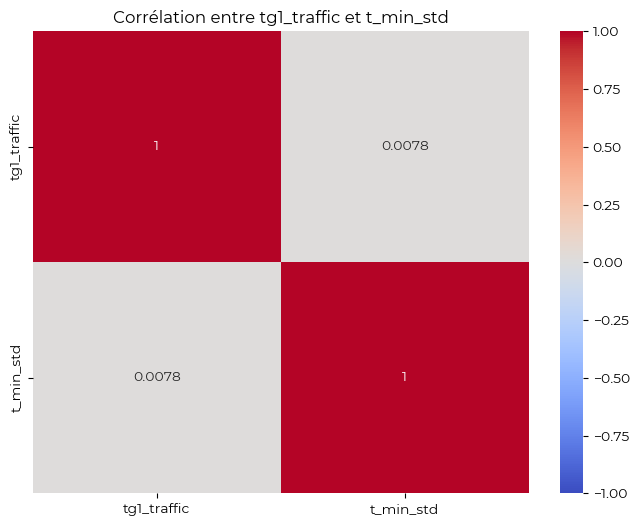

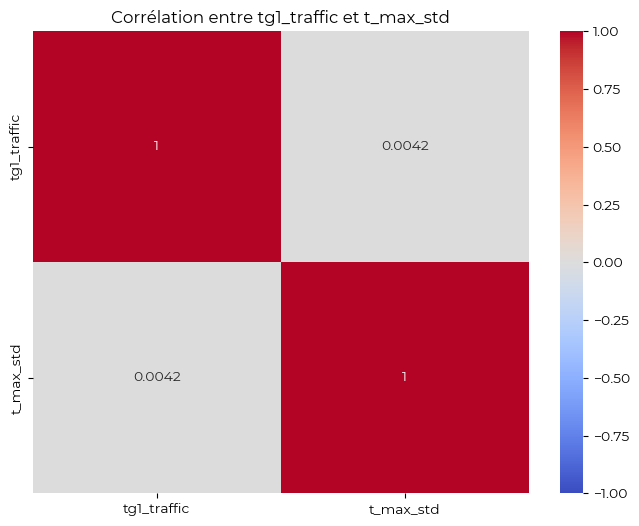

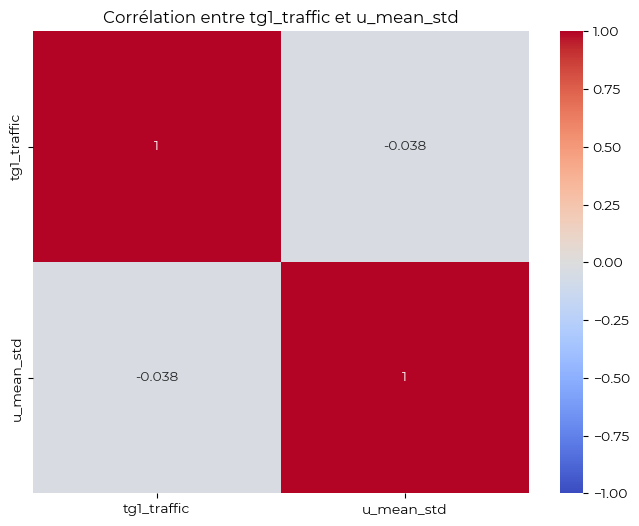

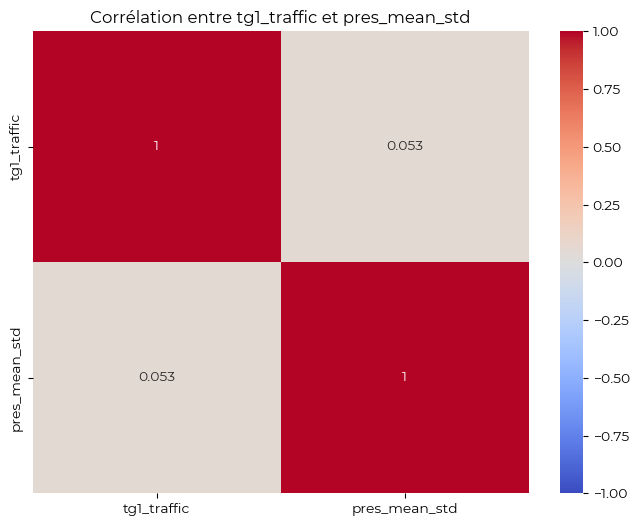

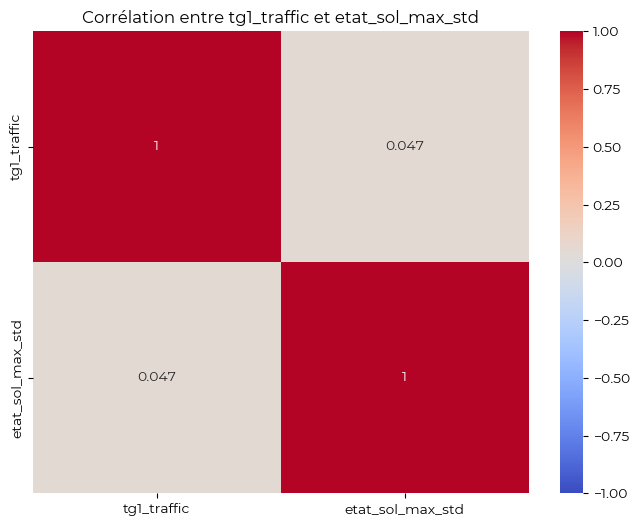

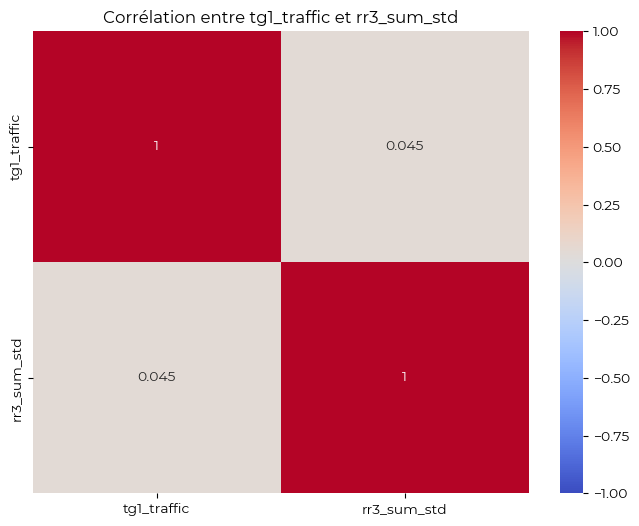

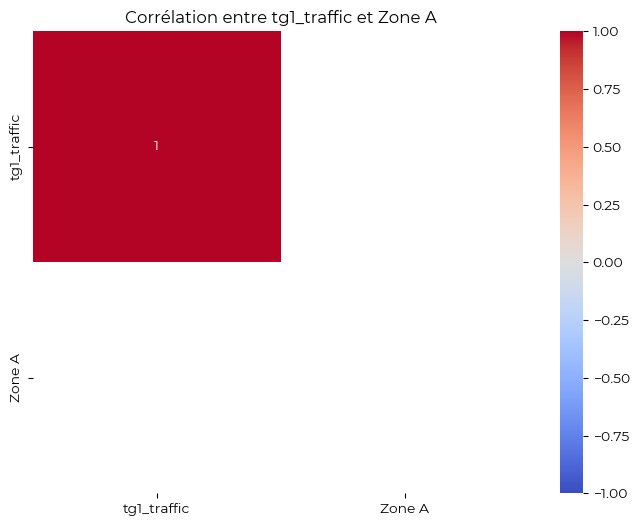

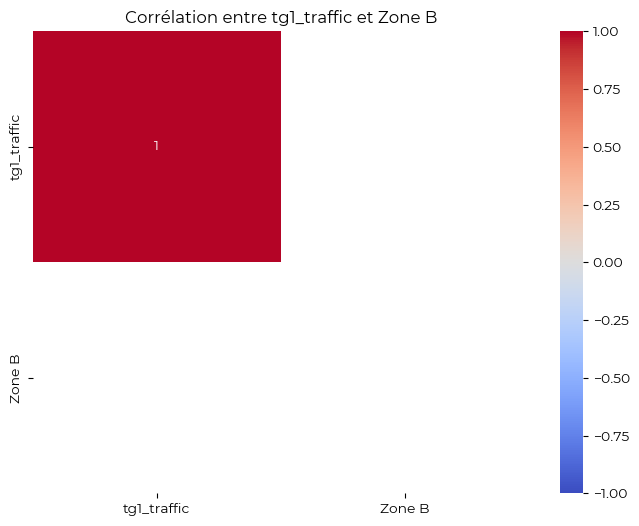

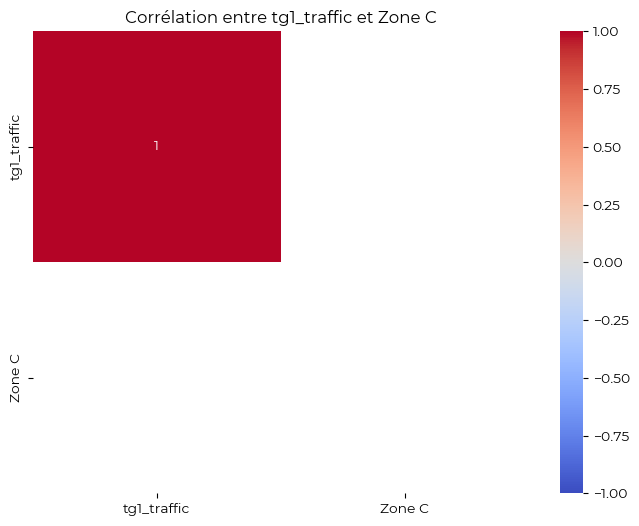

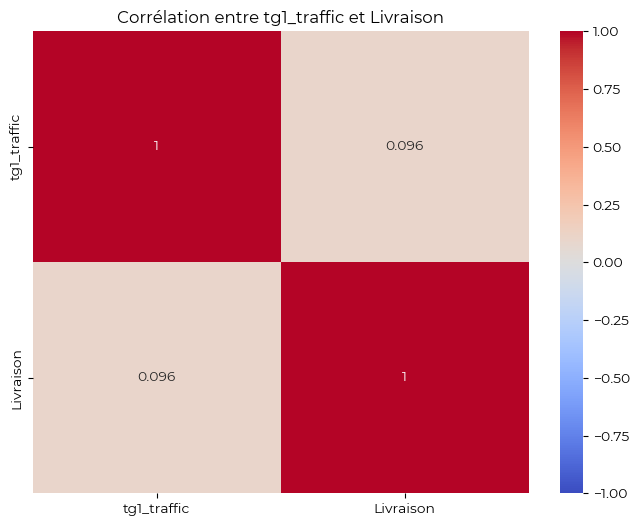

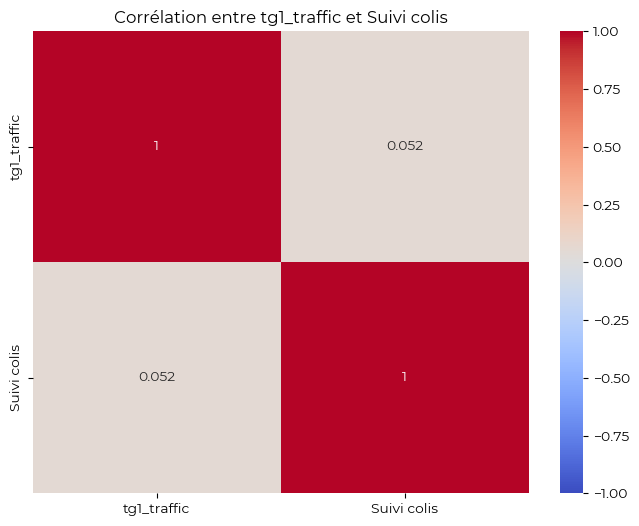

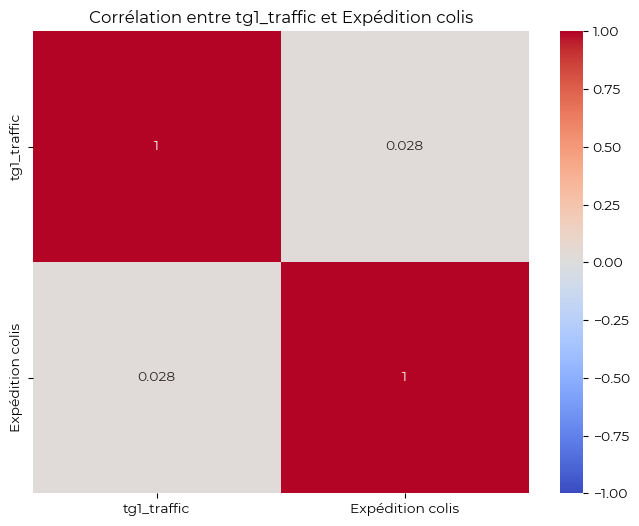

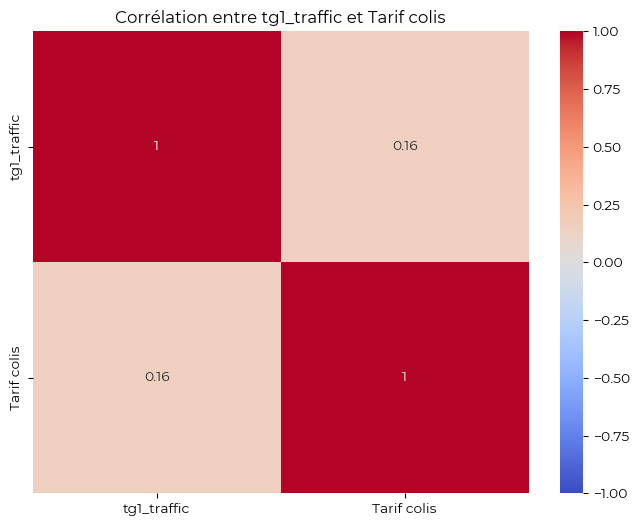

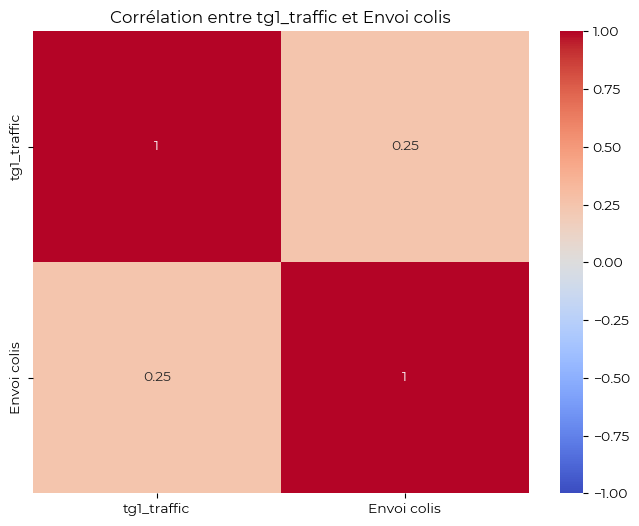

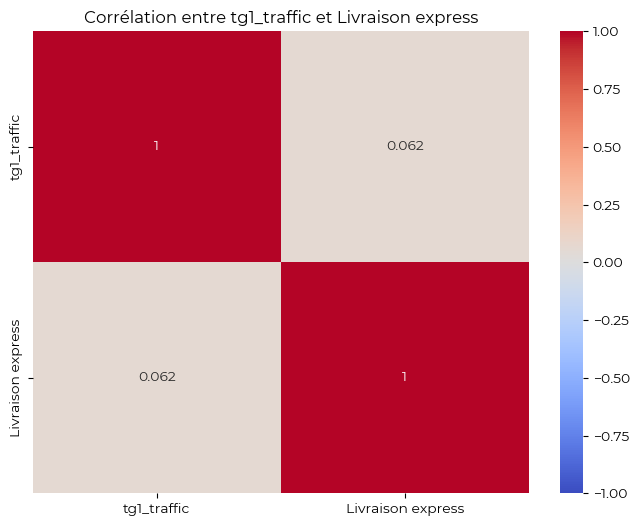

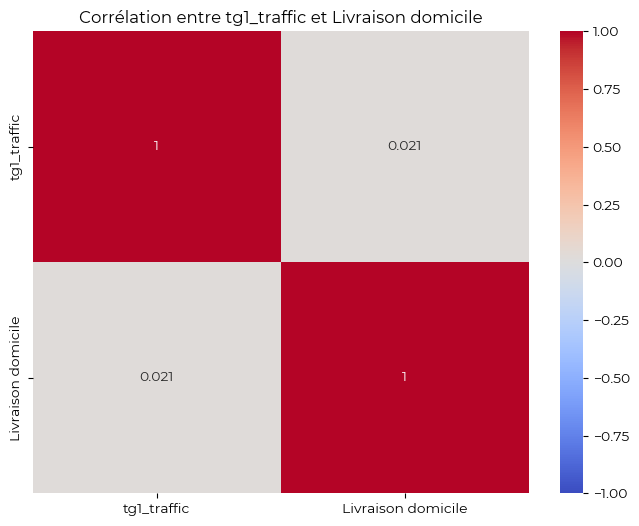

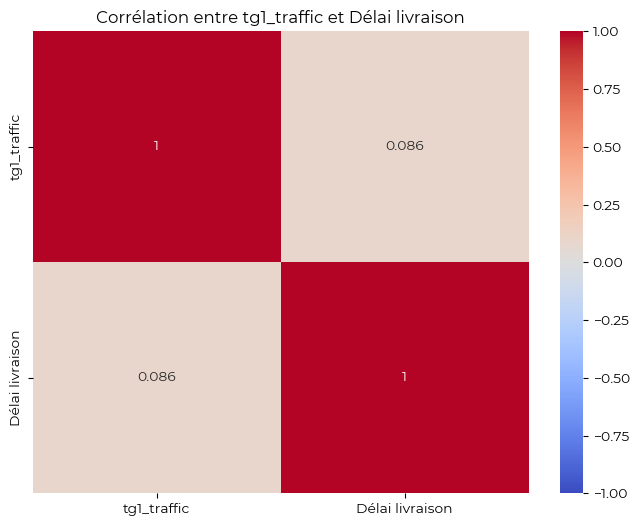

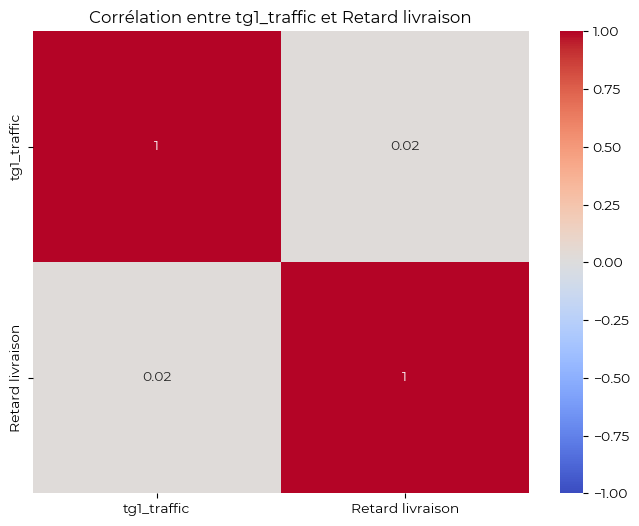

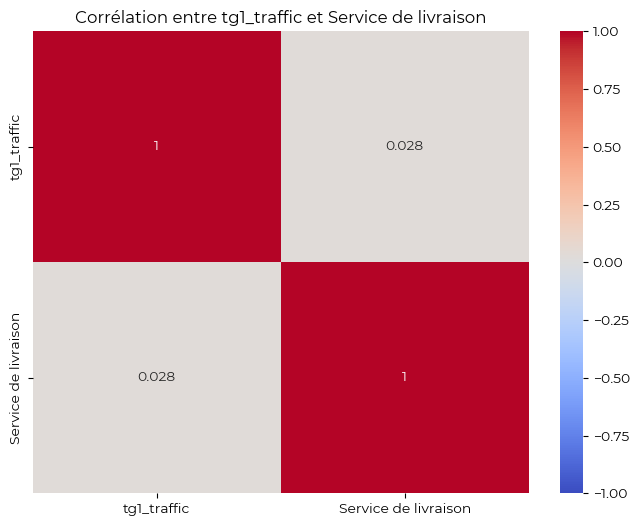

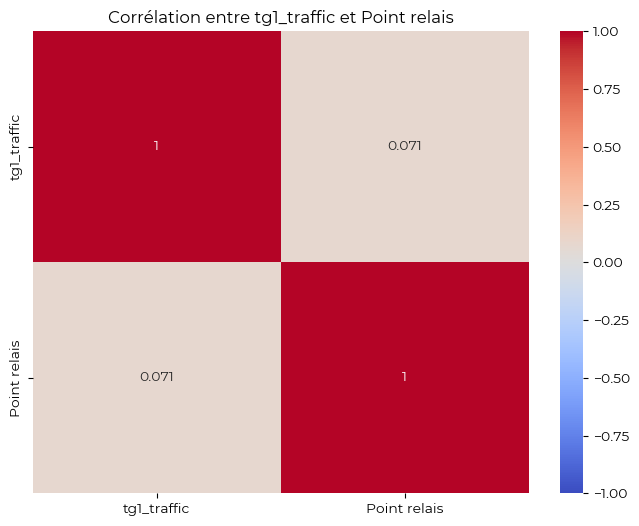

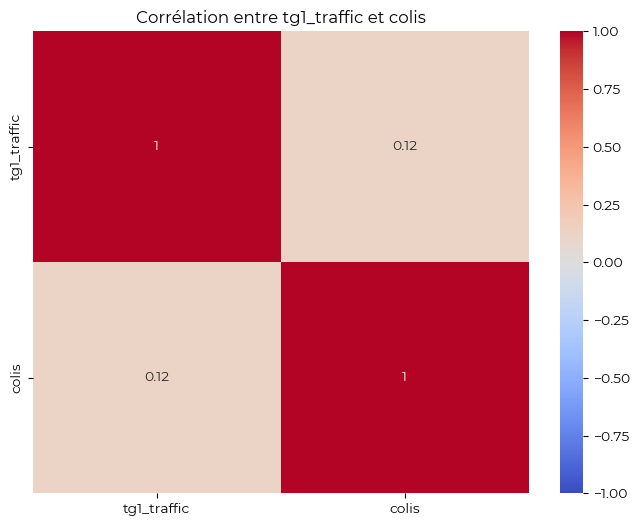

In [143]:
#heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Liste des colonnes sans 'tg1_traffic'
other_columns = [col for col in data.columns if col != 'tg1_traffic']

for col in other_columns:
    # Calculez la corrélation pour la paire de colonnes
    correlation = data[['tg1_traffic', col]].corr()
    
    # Affichez la heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Corrélation entre tg1_traffic et {col}')
    plt.show()


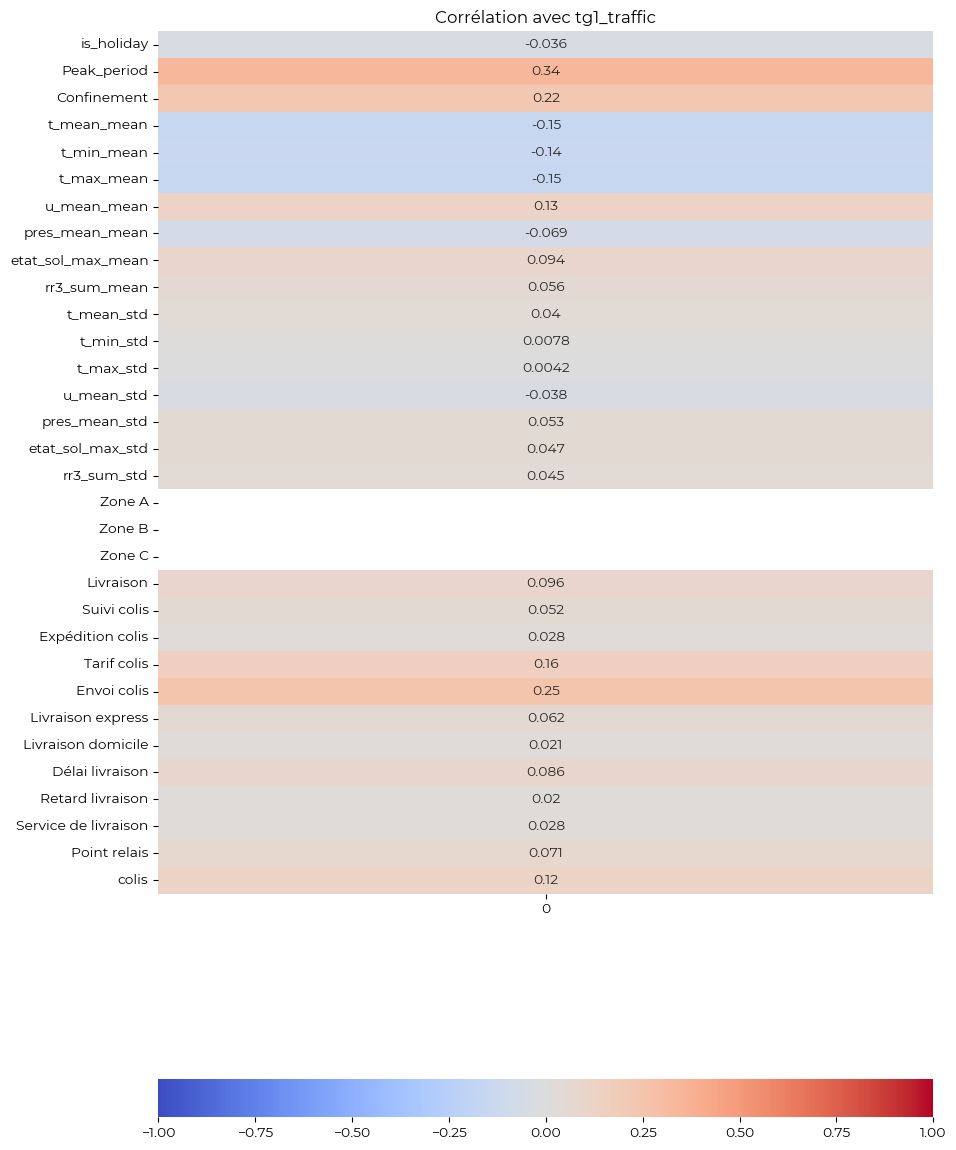

In [144]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculez la corrélation de 'tg1_traffic' avec toutes les autres colonnes
correlations = data.corrwith(data['tg1_traffic']).drop('tg1_traffic')

# Affichez une heatmap pour chaque combinaison
plt.figure(figsize=(10, len(correlations) * 0.5))
sns.heatmap(correlations.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={"orientation": "horizontal"})
plt.title('Corrélation avec tg1_traffic')
plt.show()


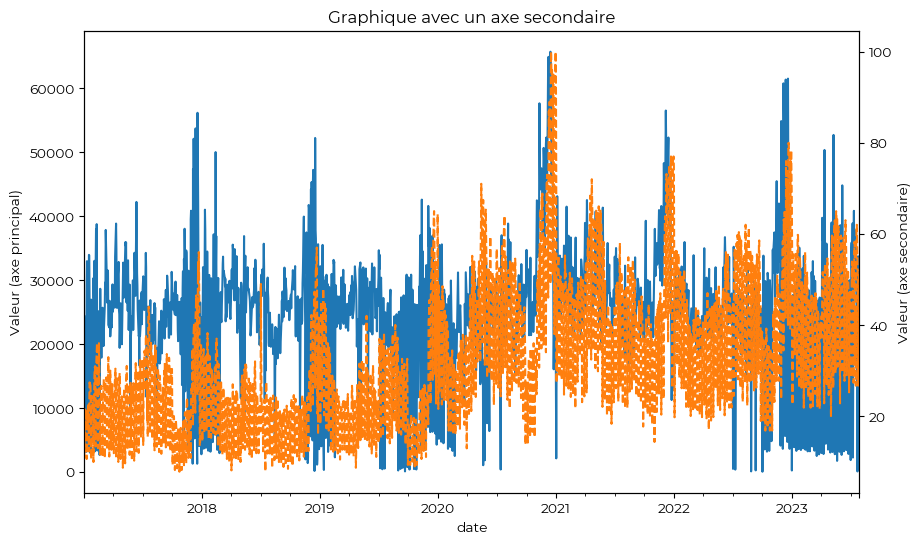

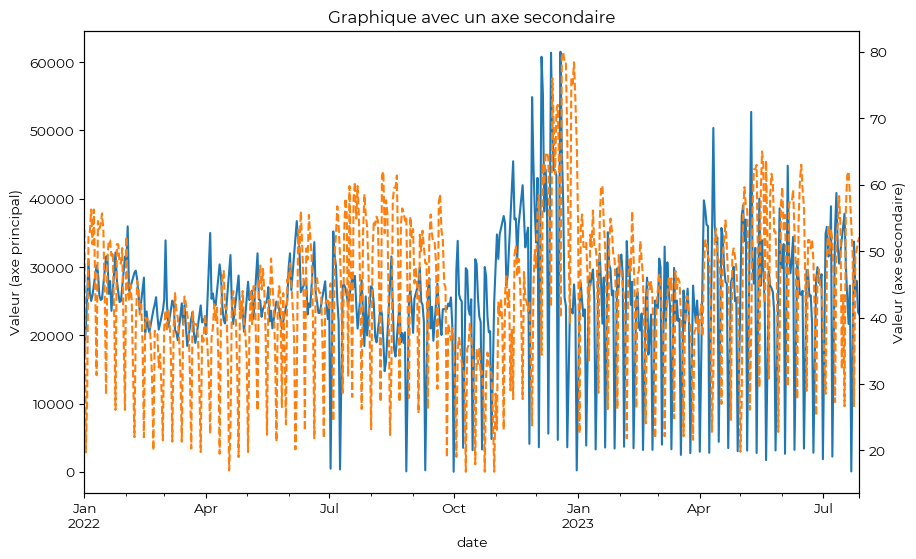

In [155]:



columns_primary_axis = 'tg1_traffic'
column_secondary_axis = 'colis'

ax = data[columns_primary_axis].plot(figsize=(10, 6))
data[column_secondary_axis].plot(secondary_y=True, ax=ax, linestyle='--')

ax.set_title('Graphique avec un axe secondaire')
ax.set_ylabel('Valeur (axe principal)')
ax.right_ax.set_ylabel('Valeur (axe secondaire)')
plt.show()

ax = data['2022-01-01':'2023-12-31'][columns_primary_axis].plot(figsize=(10, 6))
data['2022-01-01':'2023-12-31'][column_secondary_axis].plot(secondary_y=True, ax=ax, linestyle='--')

ax.set_title('Graphique avec un axe secondaire')
ax.set_ylabel('Valeur (axe principal)')
ax.right_ax.set_ylabel('Valeur (axe secondaire)')
plt.show()





# Function creation

## Custom MAPE/MAE function loss

In [100]:
def custom_mape(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    mask = tf.math.greater(y_true, 0)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)

    diff = tf.abs((y_true_masked - y_pred_masked) / y_true_masked)
    return 100. * tf.reduce_mean(diff)

def custom_mae(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    mask = tf.math.greater(y_true, 0)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)

    diff = tf.abs(y_true_masked - y_pred_masked)
    return 100. * tf.reduce_mean(diff)

## CNN model

In [101]:
def create_cnn_model(filters, kernel_size, activation, n_steps_in, n_features, optimizer, loss, 
                     reg_type=None, l1_value=0.0, l2_value=0.0):
    if reg_type == 'l1':
        kernel_regularizer = l1(l1_value)
    elif reg_type == 'l2':
        kernel_regularizer = l2(l2_value)
    elif reg_type == 'l1_l2':
        kernel_regularizer = l1_l2(l1=l1_value, l2=l2_value)
    else:
        kernel_regularizer = None
    
    model = Sequential()
    model.add(Conv1D(filters=filters, 
                     kernel_size=kernel_size, 
                     activation=activation, 
                     kernel_regularizer=kernel_regularizer, 
                     input_shape=(n_steps_in, n_features)))
    model.add(Conv1D(filters=filters, 
                     kernel_size=5, 
                     activation=activation, 
                     kernel_regularizer=kernel_regularizer))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss, metrics=[custom_mape, custom_mae])
    return model

In [167]:
#define model with model for traffic, weather and google trends
def create_parallel_cnn_model(input_meteo, input_google, input_trafic):

    #weather model
    input_weather = Input(shape=(260,164), name = 'input weather')
    weather_layer_1 = Conv1D(filters = 32, kernel_size = 20, activation = 'relu')(input_weather)
    weather_layer_2 = Conv1D(filters = 64, kernel_size = 10, activation = 'relu')(weather_layer_1)
    weather_layer_3 = Conv1D(filters = 128, kernel_size = 5, activation = 'relu')(weather_layer_2)
    weather_output = Flatten()(weather_layer_3)
    
    #google model
    input_google = Input(shape=(260,12), name = 'input google')
    google_layer_1 = Conv1D(filters = 32, kernel_size = 20, activation = 'relu')(input_google)
    google_layer_2 = Conv1D(filters = 64, kernel_size = 10, activation = 'relu')(google_layer_1)
    google_layer_3 = Conv1D(filters = 128, kernel_size = 5, activation = 'relu')(google_layer_2)
    google_output = Flatten()(google_layer_3)

    #traffic model
    input_traffic = Input(shape=(260,8), name = 'input traffic')
    traffic_layer_1 = Conv1D(filters = 32, kernel_size = 20, activation = 'relu')(input_traffic)
    traffic_layer_2 = Conv1D(filters = 64, kernel_size = 10, activation = 'relu')(traffic_layer_1)
    traffic_layer_3 = Conv1D(filters = 128, kernel_size = 5, activation = 'relu')(traffic_layer_2)
    traffic_output = Flatten()(traffic_layer_3)
    
    
    merged = concatenate(traffic_output, google_output, weather_output)
    
    # Couches denses après la fusion
    dense_1 = Dense(128, activation='relu')(merged)
    dense_2 = Dense(64, activation='relu')(dense_1)
    output = Dense(1)(dense_2)  

    # Création du modèle final
    model = Model(inputs=[input_meteo, input_google, input_trafic], outputs=output)
    model.compile(optimizer='adam', loss=custom_mape)  

    
    return model




## Scale data

In [103]:
# Scale data between 0 and 1
def scale_data(data):
    scalers = {}
    data_normalized = data.copy()
    for column in data.columns:
        scaler = MinMaxScaler()
        data_normalized[column] = scaler.fit_transform(data[[column]])
        scalers[column] = scaler
    return data_normalized, scalers

## Data transformation

In [104]:
# Define a function to transfrom data for CNN model
def transform_data_cnn(data_normalized, n_steps_in, start_date, end_date):    
    X, y, dates = [], [], []
    # Filter data based on the start and end dates
    data_filtered = data_normalized[start_date:end_date]
    # Create sequence data of n_steps_in days and n_steps_out days
    for i in range(n_steps_in, len(data_filtered)):
        X.append(data_filtered.iloc[i-n_steps_in:i])
        y.append(data_filtered.iloc[i]['tg1_traffic']) #0 because we just want to predict traffic
        dates.append(data_filtered.index[i])
    X, y, dates = np.array(X), np.array(y), np.array(dates)
    return X, y, dates




In [161]:
def transform_data_cnn_multi(data, n_steps_in, start_date, end_date, target_col='tg1_traffic'):
    # Listes pour stocker les séquences pour chaque type de données
    X_meteo, X_google_trend, X_traffic, y, dates = [], [], [], [], []
    
    # Filtrer les données en fonction des dates de début et de fin
    data_filtered = data[start_date:end_date]
    

    traffic_columns = ['tg1_traffic', 'is_holiday', 'Confinement']
    weather_columns = ['t_mean_mean','t_min_mean','t_max_mean',
                   'u_mean_mean','pres_mean_mean','etat_sol_max_mean','rr3_sum_mean']
    google_columns = ['Livraison','Suivi colis','Expédition colis',
                  'Tarif colis','Envoi colis','Livraison express','Livraison domicile',
                  'Délai livraison','Retard livraison','Service de livraison','Point relais','colis']
    
    # Créer des données séquentielles pour chaque type de données
    for i in range(n_steps_in, len(data_filtered)):
        X_meteo.append(data_filtered[weather_columns].iloc[i-n_steps_in:i].values)
        X_google_trend.append(data_filtered[google_columns].iloc[i-n_steps_in:i].values)
        X_traffic.append(data_filtered[traffic_columns].iloc[i-n_steps_in:i].values)
        
        y.append(data_filtered.iloc[i][target_col])
        dates.append(data_filtered.index[i])
    
    # Convertir les listes en tableaux numpy
    X_meteo, X_google_trend, X_traffic, y, dates = np.array(X_meteo), np.array(X_google_trend), np.array(X_traffic), np.array(y), np.array(dates)
    
    return X_meteo, X_google_trend, X_traffic, y, dates


## Transfer learning

In [105]:
def transfer_learning(X_train, y_train, n_steps_in, model_params, test_dates, y_test, model):
    # Initialize empty list to save forecast
    daily_predictions = []
    eight_day_predictions = [0] * len(test_dates)
    
    for i, date in enumerate(test_dates):
        
        # Get traffic of last day to update X_train
        if i == 0:
            new_traffic_point = y_train[-1] # for first forecast, need to take last traffic in train data
        else:
            new_traffic_point = y_test[i-1]
            
        # Create dummies for new datapoint
        current_date = test_dates[i] # forecast's day

        current_date_data = data_normalized.loc[current_date]
        new_dummies = current_date_data.iloc[1:].values


        new_data_point = np.insert(new_dummies,0,new_traffic_point )
        new_data_point_array=np.array([new_data_point])

        # Update X_train and y_train
        new_X = np.append(X_train[-1][1:], new_data_point_array, axis=0)
        X_train = np.append(X_train, [new_X], axis=0)
        y_train = np.append(y_train, [y_test[i]])
    
        # Quick update of model for learning transfer
        model.fit(X_train, y_train, epochs=1, verbose=1)

        # Make 1-day forecast
        
        prediction = model.predict(X_train[-1].reshape(1, n_steps_in, n_features), verbose=0) 
        daily_predictions.append(prediction[0])
        
        # if current date is a Thursday, need to make a 8-day forecast
        if date.weekday() == 3:
            eight_days_data = X_train[-1]
            local_predictions = []
            for k in range(6):
                if i + k < len(test_dates):  # Check that the index does not go beyond the length of test_dates
                    current_date = test_dates[i+k]
                    is_holiday = 1 if current_date in holidays_data['date'].values else 0
                    current_date_data = data_normalized.loc[current_date]
                    new_dummies = current_date_data.iloc[1:].values

                    new_prediction_point = np.insert(new_dummies,0,prediction[0][0] )
                    new_prediction_point_array=np.array([new_data_point])

                    eight_days_data = np.append(eight_days_data[1:], new_prediction_point_array, axis=0)
                    prediction = model.predict(eight_days_data.reshape(1, n_steps_in, n_features), verbose=0)
                    local_predictions.append(prediction[0])
            for j in range(min(5, len(local_predictions)-1)):
                index_to_assign = i+2+j
                if index_to_assign < len(eight_day_predictions):
                    eight_day_predictions[index_to_assign] = local_predictions[1+j][0]




    return daily_predictions, eight_day_predictions



## Rescale data

In [106]:
def rescale_predictions(predictions, scaler):
    predictions_array = np.array(predictions)
    return scaler.inverse_transform(predictions_array.reshape(-1, 1))

## Plot val results

In [107]:
def plot_test_results_from_df(df, title):
    plt.figure(figsize=(15, 7))
    plt.title(title)
    
    # Extraire les données du DataFrame
    test_dates = df.index
    y_test = df['Trafic TG1'].values
    y_test_forecast = df['Prévision globale'].values
    daily_forecast = df['Prévision journalière'].values
    weekly_forecast = df['Prévision hebdomadaire'].values


    # Remplir la zone d'erreur acceptable (+-5%)
    upper_bound = [val * 1.05 for val in y_test]
    lower_bound = [val * 0.95 for val in y_test]
    plt.fill_between(test_dates, upper_bound, lower_bound, color='blue', alpha=0.2)
    
    # Affichage de la prévision lancée d'un coup
    plt.plot(test_dates, y_test_forecast, label='Prévision globale', color='green', marker='o')
    
    # Affichage des prévisions quotidiennes
    plt.plot(test_dates, daily_forecast, label='Prévision journalière', color='red', marker='x')
    
    # Affichage des prévisions hebdomadaires
    plt.plot(test_dates, weekly_forecast, label='Prévision hebdomadaire', color='purple', marker='s')   
    
    # Affichage du trafic réel    
    plt.plot(test_dates, y_test, label='Trafic réel', color='blue', linewidth=2)
    

    plt.xlabel('Date')
    plt.ylabel('Trafic')
    plt.legend()
    plt.grid(False)
    plt.show()

## Plot train results

In [108]:
def plot_train_results_from_df(df, title):
    plt.figure(figsize=(15, 7))
    plt.title(title)
    
    # Extraire les données du DataFrame
    train_dates = df.index
    y_train = df['Trafic TG1'].values
    y_train_forecast = df['Prévision globale'].values

    # Remplir la zone d'erreur acceptable (+-5%)
    upper_bound = [val * 1.05 for val in y_train]
    lower_bound = [val * 0.95 for val in y_train]
    plt.fill_between(train_dates, upper_bound, lower_bound, color='blue', alpha=0.2)
    

    
    
    # Affichage du trafic réel    
    plt.plot(train_dates, y_train, label='Trafic réel', color='blue')
    # Affichage de la prévision lancée d'un coup
    plt.plot(train_dates, y_train_forecast, label='Prévision globale', color='green', linewidth = 2)
    

    plt.xlabel('Date')
    plt.ylabel('Trafic')
    plt.legend()
    plt.grid(False)
    plt.show()

## Calculate MAPE

In [109]:
def calculate_mean_max_mape(actual, forecast):
    # Éviter la division par zéro et les erreurs NaN
    mask = actual != 0
    mape_values = np.abs((actual[mask] - forecast[mask]) / actual[mask]) * 100
    return np.mean(mape_values), np.max(mape_values)

def compute_mape_for_columns(df, actual_col, forecast_cols):
    mape_stats = {}
    for col in forecast_cols:
        valid_forecast_mask = ~df[col].isna()
        avg_mape, max_mape = calculate_mean_max_mape(df[actual_col][valid_forecast_mask], df[col][valid_forecast_mask])
        mape_stats[col] = {"avg_mape": avg_mape, "max_mape": max_mape}
    return mape_stats

## Tuner

In [110]:
# Define the model-building function
def build_model(hp):
    model = Sequential()
    
    # Initial input size
    input_size = n_steps_in
    
    # Nouvel hyperparamètre pour le nombre de couches cachées
    num_hidden_layers = hp.Choice('num_hidden_layers', [1, 2, 3, 4, 7, 11])
    
    # Pour la première couche, nous définissons un input_shape
    filters = hp.Int(f'filters_layer_0', min_value=16, max_value=512, step=16)
    kernel_size = hp.Int(f'kernel_size_layer_0', min_value=3, max_value=90, step=2)
    
    # Check output size
    output_size = input_size - kernel_size + 1
    if output_size <= 0:
        return model  # Terminate early if invalid configuration
    
    model.add(Conv1D(filters=filters, 
                     kernel_size=kernel_size, 
                     activation='relu', 
                     input_shape=(n_steps_in, n_features)))  
    
    # Ajout du nombre requis de couches cachées
    for i in range(1, num_hidden_layers):
        filters = hp.Int(f'filters_layer_{i}', min_value=16, max_value=128, step=16)
        kernel_size = hp.Int(f'kernel_size_layer_{i}', min_value=3, max_value=90, step=2)
        
        # Update input size
        input_size = output_size
        # Check output size
        output_size = input_size - kernel_size + 1
        if output_size <= 0:
            break  # Stop adding layers if invalid configuration
        
        model.add(Conv1D(filters=filters, 
                         kernel_size=kernel_size, 
                         activation='relu'))
    
    model.add(Flatten())
    model.add(Dense(1))
    
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop'])
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    
    if optimizer == 'adam':
        opt = legacy_optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = legacy_optimizers.RMSprop(learning_rate=learning_rate)
    
    model.compile(optimizer=opt, loss=custom_mape, metrics=[custom_mape, custom_mae])
    return model


# Data preparation

Take out saturday and sunday of data, normalized the data before creating training and test dataset.
<br>
n_steps_in is the number of week $\times$ number of day in a week (here 5)

In [32]:
# Exclusion des jours de la semaine (samedi et dimanche)
data = data[(data.index.dayofweek != 5) & (data.index.dayofweek != 6)]

data_normalized, scaler = scale_data(data)

n_features = data.shape[1] 

n_steps_in =260

X_train, y_train, train_dates = transform_data_cnn(data_normalized, 
                                                   n_steps_in,  
                                                   '2017-01-01', 
                                                   '2020-12-31')

X_val, y_val, val_dates = transform_data_cnn(data_normalized, 
                                                n_steps_in, 
                                                '2021-01-01', 
                                                '2022-12-31')

In [163]:
# Exclusion des jours de la semaine (samedi et dimanche)
data = data[(data.index.dayofweek != 5) & (data.index.dayofweek != 6)]

data_normalized, scaler = scale_data(data)

n_steps_in =260

weather_train, google_train, traffic_train, y_train, train_dates =  transform_data_cnn_multi(data_normalized,
                                                                                   n_steps_in,
                                                                                   '2017-01-01', 
                                                                                   '2020-12-31')

weather_val, google_val, traffic_val, y_val,  val_dates =  transform_data_cnn_multi(data_normalized,
                                                                                   n_steps_in,
                                                                                   '2021-01-01', 
                                                                                   '2022-12-31')


# Tuning

In [ ]:
directory_to_delete = "keras_tuner_dir"
shutil.rmtree(directory_to_delete)

early_stop = EarlyStopping(monitor='val_custom_mape', patience=10, restore_best_weights=True)

# Définissez la recherche d'hyperparamètres
tuner = BayesianOptimization(
    build_model,
    objective=Objective(name='val_custom_mape', direction='min'),  # Nous optimisons sur la MAPE
    max_trials=100,  # nombre d'essais pour le tuning
    directory='keras_tuner_dir',  # dossier pour stocker les logs
    project_name='traffic_optimization'
)

# Recherche des meilleurs hyperparamètres
tuner.search(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=10, 
    callbacks=[early_stop]
)


best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]






In [ ]:
# Récupérer les essais
trials = tuner.oracle.trials

# Créer une liste pour stocker les données
data = []

# Boucler à travers les essais
for trial in trials.values():
    trial_data = {}
    trial_data['trial_id'] = trial.trial_id
    for k, v in trial.hyperparameters.values.items():
        trial_data[k] = v
    trial_data['score'] = trial.score
    data.append(trial_data)

# Convertir la liste en DataFrame
df_trials = pd.DataFrame(data)

# Trier le DataFrame par 'custom_mape' croissant
df_sorted = df_trials.sort_values(by='score', ascending=True)
df_sorted = df_sorted[['score','num_hidden_layers','filters_layer_0','kernel_size_layer_0','optimizer','learning_rate']]
print(df_sorted)
df_sorted.to_csv('test')

# Model creation

## Model parameters

In [33]:

# CNN model parameters
model_params_CNN = {
    "filters": 64,
    "kernel_size": 20,
    "activation": "relu",
    "n_steps_in": n_steps_in,
    "n_features": n_features,
    "optimizer": 'adam',
    "loss": custom_mape
}

## Model creation

In [168]:
#cnn_model = create_cnn_model(**model_params_CNN)

#cnn_model = create_deep_cnn_model()
cnn = create_parallel_cnn_model(weather_train, google_train, traffic_train)


history = cnn.fit([weather_train, google_train, traffic_train], 
                    y_train, 
                    epochs=40,                     
                    validation_data=([weather_val, google_val, traffic_val], y_val))





TypeError: concatenate() takes from 1 to 2 positional arguments but 3 were given

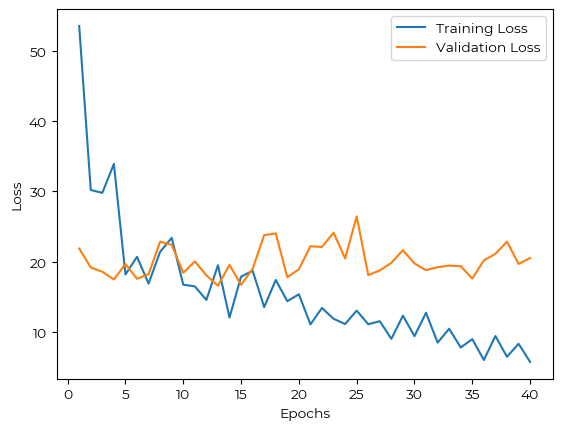

In [86]:
# Historique des pertes
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Global forecast

In [87]:
y_train_forecast = cnn_model.predict(X_train)
y_val_forecast = cnn_model.predict(X_val)

25/25 [==============================] - 0s 4ms/step


2023-08-30 10:17:20.160164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 0s 4ms/step


## Daily and Weekly Forecast

In [88]:
start_time = time.time()
daily_forecast, weekly_forecast = transfer_learning(X_train,y_train,n_steps_in,model_params_CNN, val_dates,y_val,cnn_model)
print("--- Transfert d'apprentissage: %s seconds ---" % (time.time() - start_time))

27/27 [==============================] - 0s 9ms/step - loss: 5.9035 - custom_mape: 5.8789 - custom_mae: 1.3648


30/30 [==============================] - 0s 8ms/step - loss: 3.9221 - custom_mape: 3.8965 - custom_mae: 1.0936


32/32 [==============================] - 0s 8ms/step - loss: 4.0137 - custom_mape: 4.0999 - custom_mae: 1.0857


33/33 [==============================] - 0s 8ms/step - loss: 3.1172 - custom_mape: 3.1198 - custom_mae: 1.0466
--- Transfert d'apprentissage: 89.87686705589294 seconds ---


# Data analysis

## Rescale data

In [89]:
y_train_forecast_rescaled = rescale_predictions(y_train_forecast, scaler['tg1_traffic'])
y_train_rescaled = rescale_predictions(y_train, scaler['tg1_traffic'])


y_val_forecast_rescaled = rescale_predictions(y_val_forecast, scaler['tg1_traffic'])
y_val_rescaled = rescale_predictions(y_val, scaler['tg1_traffic'])



daily_forecast_rescaled = rescale_predictions(daily_forecast, scaler['tg1_traffic'])
weekly_forecast_rescaled = rescale_predictions(weekly_forecast, scaler['tg1_traffic'])

## Concatenate forecast in dataframe

In [90]:
data_train_forecast = pd.DataFrame({
    'Trafic TG1' : y_train_rescaled.flatten().tolist() ,
    'Prévision globale' : y_train_forecast_rescaled.flatten().tolist()
                            }, index = train_dates.tolist())

data_test_forecast = pd.DataFrame({
    'Trafic TG1' : y_val_rescaled.flatten().tolist() ,
    'Prévision globale' : y_val_forecast_rescaled.flatten().tolist(),
   'Prévision hebdomadaire' : weekly_forecast_rescaled.flatten().tolist(),
    'Prévision journalière' : daily_forecast_rescaled.flatten().tolist()  
                            }, index = val_dates.tolist())



In [91]:
#update date with holidays

#holidays
data_train_forecast.loc[data_train_forecast.index.isin(holidays_data['date']), 'Prévision globale'] = 0
data_test_forecast.loc[data_test_forecast.index.isin(holidays_data['date']), 'Prévision globale'] = 0
data_test_forecast.loc[data_test_forecast.index.isin(holidays_data['date']), 'Prévision hebdomadaire'] = 0
data_test_forecast.loc[data_test_forecast.index.isin(holidays_data['date']), 'Prévision journalière'] = 0

## Plot results

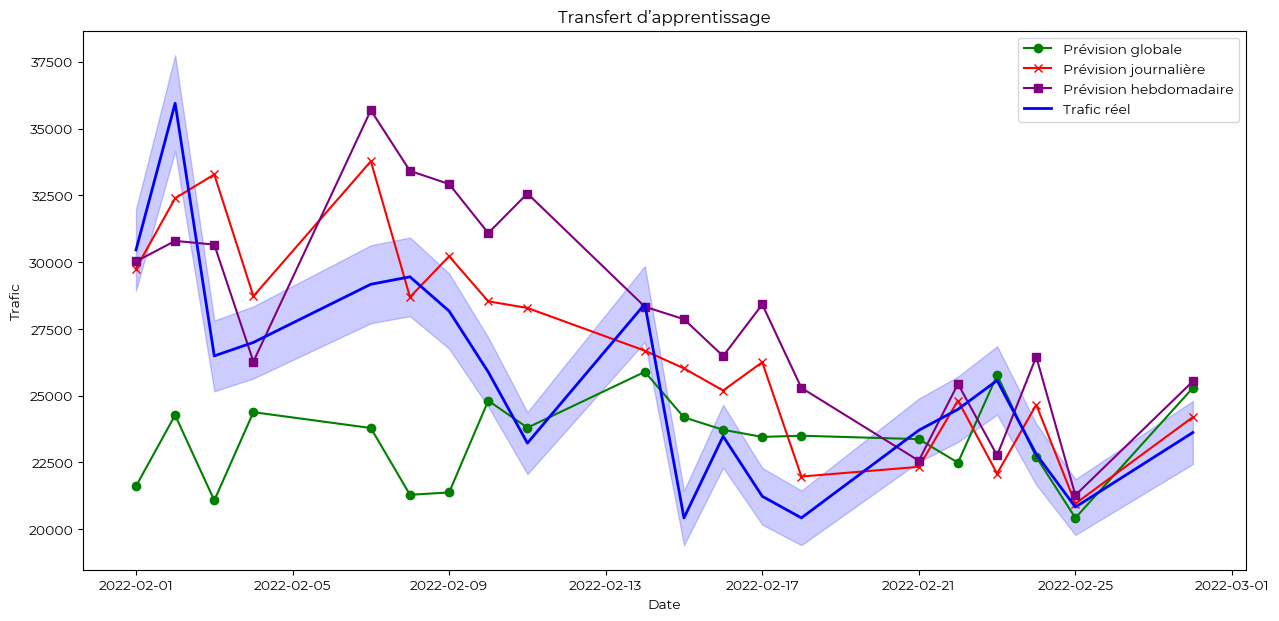

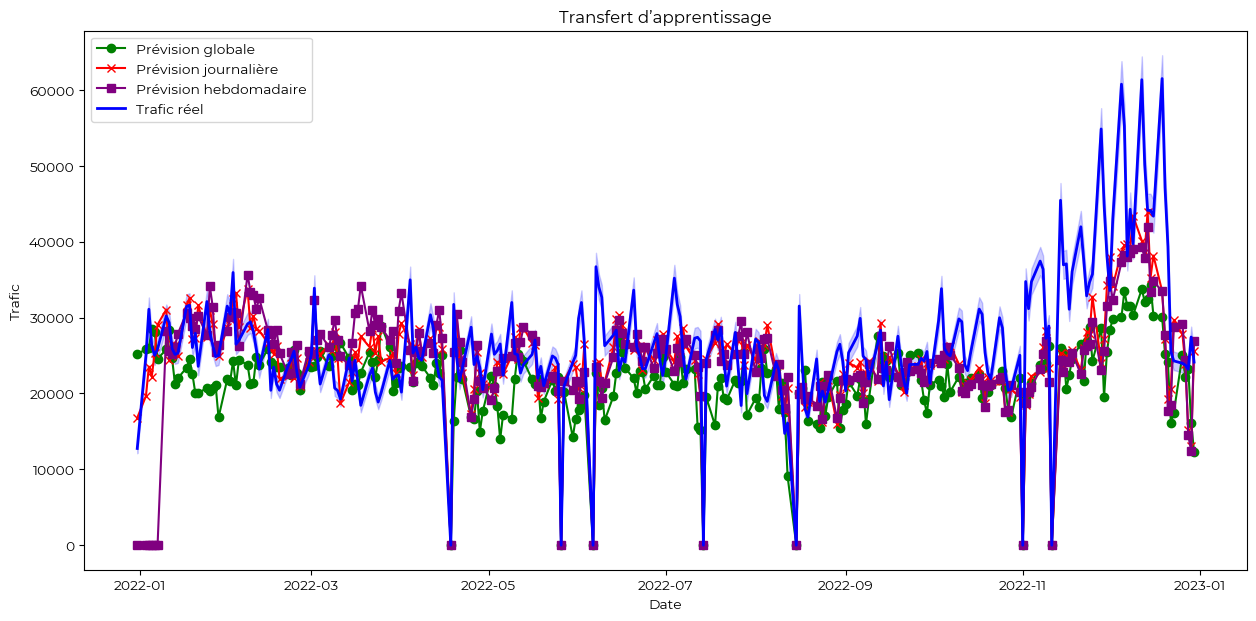

In [112]:
plot_test_results_from_df(data_test_forecast['2022-02-01':'2022-02-28'], 'Transfert d’apprentissage')
plot_test_results_from_df(data_test_forecast, 'Transfert d’apprentissage')

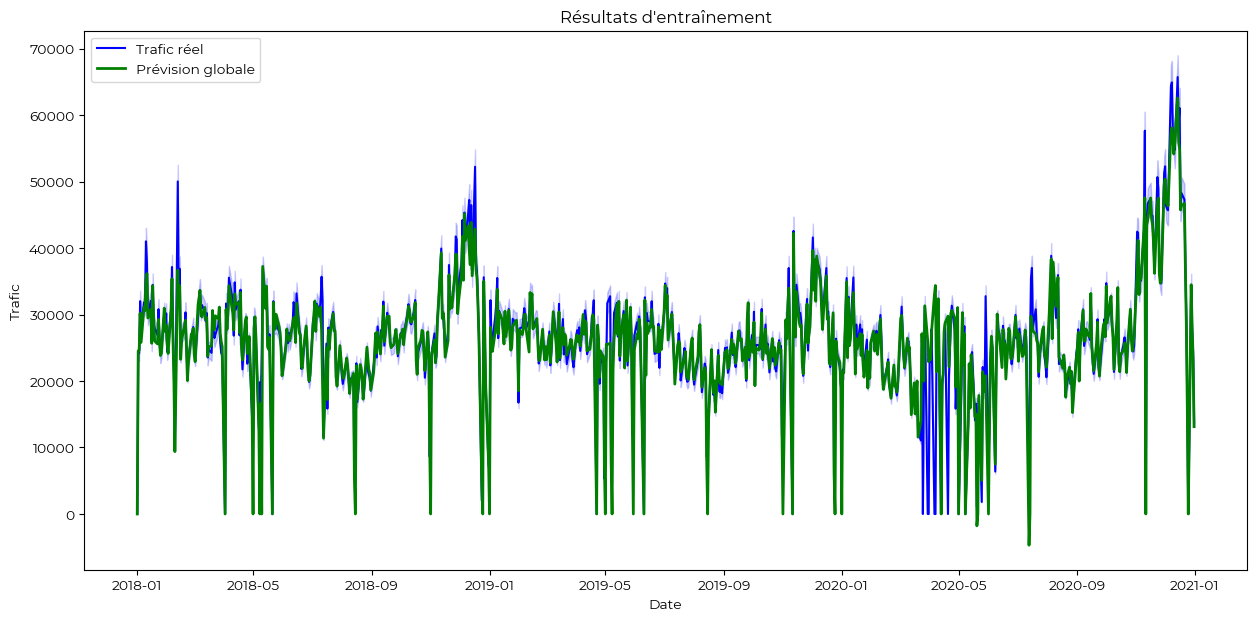

In [93]:
plot_train_results_from_df(data_train_forecast, "Résultats d'entraînement")

## Metrics

In [94]:
# Utilisation de la fonction:
forecast_columns = ['Prévision globale', 'Prévision journalière', 'Prévision hebdomadaire']
mapes = compute_mape_for_columns(data_test_forecast, 'Trafic TG1', forecast_columns)

for col, mape_stats in mapes.items():
    avg_mape = mape_stats['avg_mape']
    max_mape = mape_stats['max_mape']
    print(f"MAPE moyen {col} : {avg_mape:.2f}%")
    print(f"MAPE max {col} : {max_mape:.2f}%")
    print("-" * 30)  # Juste pour séparer visuellement les différentes prévisions


MAPE moyen Prévision globale : 20.48%
MAPE max Prévision globale : 97.28%
------------------------------
MAPE moyen Prévision journalière : 15.80%
MAPE max Prévision journalière : 56.32%
------------------------------
MAPE moyen Prévision hebdomadaire : 20.70%
MAPE max Prévision hebdomadaire : 100.00%
------------------------------


In [95]:
# Utilisation de la fonction:
forecast_columns = ['Prévision globale']
mapes = compute_mape_for_columns(data_train_forecast, 'Trafic TG1', forecast_columns)

for col, mape_stats in mapes.items():
    avg_mape = mape_stats['avg_mape']
    max_mape = mape_stats['max_mape']
    print(f"MAPE moyen {col} : {avg_mape:.2f}%")
    print(f"MAPE max {col} : {max_mape:.2f}%")

MAPE moyen Prévision globale : 8.12%
MAPE max Prévision globale : 1406.08%


# Tuning

## Run CNN

In [ ]:
def run_cnn(model_params):
    cnn_model = create_cnn_model(**model_params)
    history = cnn_model.fit(X_train, y_train, epochs=60)
    # Historique des pertes
    train_loss = history.history['loss']

    epochs = range(1, len(train_loss) + 1)

    plt.plot(epochs, train_loss, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    y_train_forecast = cnn_model.predict(X_train)
    y_test_forecast = cnn_model.predict(X_test)

    daily_forecast, weekly_forecast = transfer_learning(X_train,y_train,n_steps_in,model_params,test_dates,y_test,cnn_model)
    
    y_train_forecast_rescaled = rescale_predictions(y_train_forecast, scaler['tg1_traffic'])
    y_train_rescaled = rescale_predictions(y_train, scaler['tg1_traffic'])


    y_test_forecast_rescaled = rescale_predictions(y_test_forecast, scaler['tg1_traffic'])
    y_test_rescaled = rescale_predictions(y_test, scaler['tg1_traffic'])



    daily_forecast_rescaled = rescale_predictions(daily_forecast, scaler['tg1_traffic'])
    weekly_forecast_rescaled = rescale_predictions(weekly_forecast, scaler['tg1_traffic'])
    
    data_train_forecast = pd.DataFrame({
    'Trafic TG1' : y_train_rescaled.flatten().tolist() ,
    'Prévision globale' : y_train_forecast_rescaled.flatten().tolist()
                            }, index = train_dates.tolist())

    data_test_forecast = pd.DataFrame({
    'Trafic TG1' : y_test_rescaled.flatten().tolist() ,
    'Prévision globale' : y_test_forecast_rescaled.flatten().tolist(),
    'Prévision hebdomadaire' : weekly_forecast_rescaled.flatten().tolist(),
    'Prévision journalière' : daily_forecast_rescaled.flatten().tolist()  
                            }, index = test_dates.tolist())
    
    plot_test_results_from_df(data_test_forecast, 'Transfert d’apprentissage')
    plot_train_results_from_df(data_train_forecast, "Résultats d'entraînement")
    
    mapes_train = {}
    mapes_test = {}
    
    # Calcul des MAPE pour les données d'entraînement
    forecast_columns_train = ['Prévision globale']
    mapes_train = compute_mape_for_columns(data_train_forecast, 'Trafic TG1', forecast_columns_train)
    
    for col, values in mapes_train.items():
        avg_mape = values['avg_mape']
        max_mape = values['max_mape']
        print(f"Train MAPE {col} - Average: {avg_mape:.2f}% | Max: {max_mape:.2f}%")
    
    # Calcul des MAPE pour les données de test
    forecast_columns_test = ['Prévision globale', 'Prévision journalière', 'Prévision hebdomadaire']
    mapes_test = compute_mape_for_columns(data_test_forecast, 'Trafic TG1', forecast_columns_test)
    
    for col, values in mapes_test.items():
        avg_mape = values['avg_mape']
        max_mape = values['max_mape']
        print(f"Test MAPE {col} - Average: {avg_mape:.2f}% | Max: {max_mape:.2f}%")

    return mapes_train, mapes_test

## Run LSTM

In [ ]:
def run_lstm(model_params):
    lstm_model = create_lstm_model(**model_params)
    history = lstm_model.fit(X_train, y_train, epochs=40, validation_data=(X_val, y_val))
    # Historique des pertes
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(train_loss) + 1)

    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    y_train_forecast = lstm_model.predict(X_train)
    y_val_forecast = lstm_model.predict(X_test)

    daily_forecast, weekly_forecast = transfer_learning(X_train,y_train,n_steps_in,model_params,val_dates,y_val,lstm_model)
    
    y_train_forecast_rescaled = rescale_predictions(y_train_forecast, scaler['tg1_traffic'])
    y_train_rescaled = rescale_predictions(y_train, scaler['tg1_traffic'])


    y_val_forecast_rescaled = rescale_predictions(y_val_forecast, scaler['tg1_traffic'])
    y_val_rescaled = rescale_predictions(y_val, scaler['tg1_traffic'])



    daily_forecast_rescaled = rescale_predictions(daily_forecast, scaler['tg1_traffic'])
    weekly_forecast_rescaled = rescale_predictions(weekly_forecast, scaler['tg1_traffic'])
    
    data_train_forecast = pd.DataFrame({
    'Trafic TG1' : y_train_rescaled.flatten().tolist() ,
    'Prévision globale' : y_train_forecast_rescaled.flatten().tolist()
                            }, index = train_dates.tolist())

    data_val_forecast = pd.DataFrame({
    'Trafic TG1' : y_val_rescaled.flatten().tolist() ,
    'Prévision globale' : y_val_forecast_rescaled.flatten().tolist(),
    'Prévision hebdomadaire' : weekly_forecast_rescaled.flatten().tolist(),
    'Prévision journalière' : daily_forecast_rescaled.flatten().tolist()  
                            }, index = test_dates.tolist())
    
    plot_test_results_from_df(data_val_forecast, 'Transfert d’apprentissage')
    plot_train_results_from_df(data_train_forecast, "Résultats d'entraînement")
    
    # Utilisation de la fonction:
    forecast_columns = ['Prévision globale', 'Prévision journalière', 'Prévision hebdomadaire']
    mapes = compute_mape_for_columns(data_val_forecast, 'Trafic TG1', forecast_columns)
    print(mapes)

    for col, values in mapes.items():
        avg_mape = values['avg_mape']
        max_mape = values['max_mape']
        print(f"MAPE {col} - Average: {avg_mape:.2f}% | Max: {max_mape:.2f}%")

        
    # Utilisation de la fonction:
    forecast_columns = ['Prévision globale']
    mapes = compute_mape_for_columns(data_train_forecast, 'Trafic TG1', forecast_columns)
    for col, values in mapes.items():
        avg_mape = values['avg_mape']
        max_mape = values['max_mape']
        print(f"MAPE {col} - Average: {avg_mape:.2f}% | Max: {max_mape:.2f}%")

## Build CNN

In [ ]:
# Paramètres du modèle

from datetime import datetime, timedelta

filters = [64, 128]
kernels = [14, 21]
list1 = [0, 1e-1, 1e-2, 1e-3, 1e-4]
list2 = [0, 1e-1, 1e-2, 1e-3, 1e-4]
reg_type = ["l1", "l2", "l1_l2"]



for filt in filters:
    for kernel in kernels:
            for reg in reg_type:
                # Si 'reg' est "l1", alors on n'a besoin que de parcourir les valeurs de "l1".
                # De même pour "l2". Si 'reg' est "l1_l2", alors on parcourt les deux listes.
                l1_values = list1 if reg in ['l1', 'l1_l2'] else [None]
                l2_values = list2 if reg in ['l2', 'l1_l2'] else [None]

                for L1 in l1_values:
                    for L2 in l2_values:
                        print(filt, kernel, reg, L1, L2)
                        model_params_cnn = {
                            "filters": filt,
                            "kernel_size": kernel,
                            "activation": "relu",
                            "n_steps_in": n_steps_in,
                            "n_features": 2,
                            "optimizer": 'adam',
                            "loss": custom_mape,
                            "reg_type" : reg,
                            "l1_value" : L1,
                            "l2_value" : L2
                        }

                        mapes_train, mapes_test = run_cnn(model_params_cnn)

                        results.append({
                            'filters': filt,
                            'kernel': kernel,
                            'reg_type': reg,
                            'l1_value': L1,
                            'l2_value': L2,
                            'mapes_train': mapes_train,
                            'mapes_test': mapes_test
                        })


results_df = pd.DataFrame(results)        
            

In [ ]:
print(results)


In [ ]:
import pandas as pd

# Transformez les dictionnaires en colonnes
mapes_train_df = pd.json_normalize(results_df['mapes_train'])
mapes_test_df = pd.json_normalize(results_df['mapes_test'])

# Renommez les colonnes pour une meilleure clarté
mapes_train_df.columns = [col.replace("Prévision globale.", "train_") for col in mapes_train_df.columns]
mapes_test_df.columns = [col.replace("Prévision globale.", "test_") for col in mapes_test_df.columns]

# Supprimez les colonnes originales "mapes_train" et "mapes_test"
results_df.drop(columns=['mapes_train', 'mapes_test'], inplace=True)

# Concaténez les dataframes pour obtenir le résultat final
df = pd.concat([results_df, mapes_train_df, mapes_test_df], axis=1)


print(df)

In [ ]:
df = results.copy()
print(df)

In [ ]:
# Convertir la liste en DataFrame
df = pd.DataFrame(results)

# Si vous souhaitez aplatir les dictionnaires imbriqués, vous pouvez utiliser `json_normalize`
df_flat = pd.json_normalize(results)

# Exporter en CSV
df.to_csv("your_file.csv", index=False)
df_flat.to_csv("your_file_flat.csv", index=False)

print(df_flat)

In [ ]:
df = pd.concat([df])
print(df)
df.to_csv("data.csv", index=False)

In [ ]:
print(data_train_forecast)